In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind,pearsonr, kendalltau, spearmanr

# Inputs

external_csv = r"C:\Users\Andris\Documents\GitHub\data\clean\school_ext_data.csv"
internal_csv = r"C:\Users\Andris\Documents\GitHub\data\clean\school_clk_data.csv"


In [94]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))

# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

for item in qu:
    df['exam_improv_2013-2014_' + item] = (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]).mean()

for item in qu:
    df['exam_improv_2013-2016_' + item] = (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]).mean()

# Student activity
df['student_activity'] =  (df.filter(regex='_cor_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)

# Log student activity
df['log_student_activity'] =  np.log(df['student_activity']+1)

# ------------------------------------------------------
# CLEANING THE DATA
# ------------------------------------------------------

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

#  Fill all schools that have no IDACI rating with -1
#df['IDACI'] = [-1 if item == 0 else item for item in df['IDACI']]

# Select the schools that have provide all science courses in all years
df = df[(df.filter(regex='Entries') > 0).all(axis=1)]

# Remove any unecessary features
df = df.drop(df.filter(regex='Entries|exam_score'),axis=1)

# Creating another dataframe that has removed outliers (who fall outside the 95% percentile)
q = df[['student_activity']].quantile(0.95)
df_out = df[(df[q.keys()] < q).all(axis=1)]

#print(df)
df.head(5)

,IDACI,Effectiveness,Teach_quality,L_M_index,PercentageFSM,q_lvl_2_cor_tch,view_concept_tch,q_lvl_3_cor_tch,q_lvl_2_tch,q_lvl_0_cor_tch,...,exam_improv_2013-2014_Biology,exam_improv_2013-2014_Mathematics,exam_improv_2013-2014_Chemistry,exam_improv_2013-2014_Physics,exam_improv_2013-2016_Biology,exam_improv_2013-2016_Mathematics,exam_improv_2013-2016_Chemistry,exam_improv_2013-2016_Physics,student_activity,log_student_activity
URN,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.036272,-0.003697,-0.061495,-0.099692,0.029736,-0.043330,-0.003100,-0.062738,16.300000,2.850707
100003,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,29.0,...,-0.080350,-0.020661,-0.019674,0.052747,-0.020112,-0.013455,-0.009502,0.106763,72.774194,4.301009
100054,5.0,1.0,1.0,1.0,19.7,1.0,8.0,1.0,3.0,0.0,...,0.138762,-0.006687,0.016362,0.015041,-0.035131,-0.017300,0.003301,-0.038957,17.307692,2.907321
100065,0.0,0.0,0.0,0.0,0.0,8.0,10.0,12.0,49.0,44.0,...,0.096233,0.001924,0.015242,0.059983,0.064762,-0.037641,0.037853,0.113732,72.114286,4.292024
100076,0.0,0.0,0.0,0.0,0.0,22.0,2.0,35.0,78.0,0.0,...,-0.107807,0.032783,-0.044749,-0.167057,-0.109535,-0.023395,-0.024589,-0.062783,1.714286,0.998529


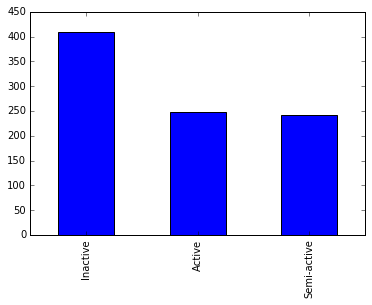

In [69]:
def bin_groups(df, feature, bins, group_names):
    
    categories = pd.cut(df[feature],bins, labels=group_names)
    return categories

# ----------------------------- -------------------------
# Binning by student activity
# ------------------------------------------------------

group_names = ['Inactive','Semi-active','Active']
bins = [-2, 0, 10,10000]

df['categories'] = bin_groups(df,'student_activity',bins,group_names)

# Plot a histogram
df['categories'].value_counts().plot(kind='bar')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000002980547160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000298039ACF8>]], dtype=object)

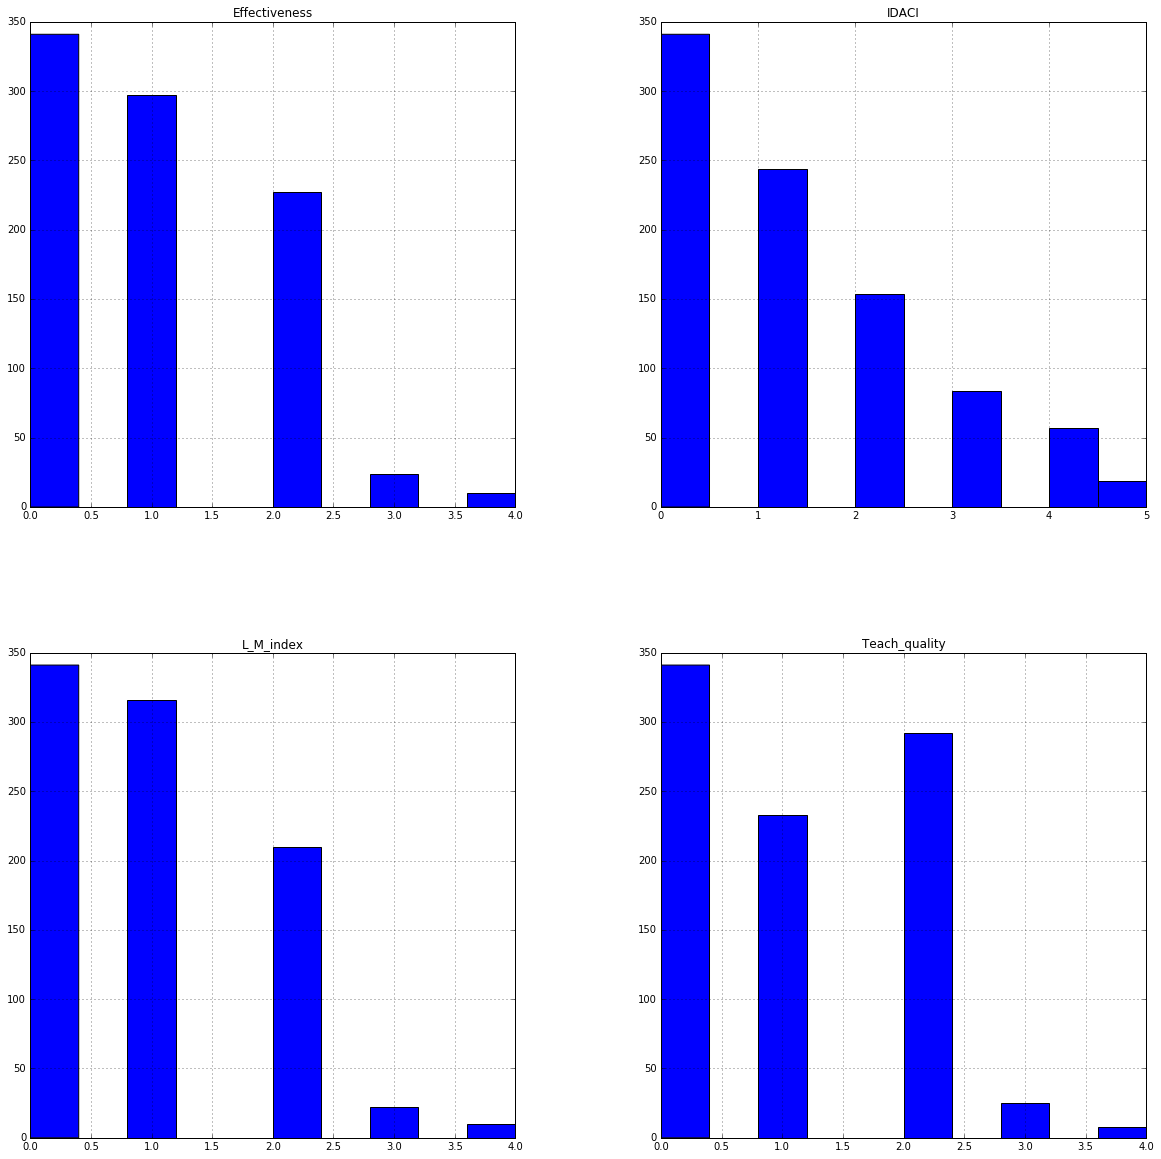

In [95]:
df[['IDACI','L_M_index','Effectiveness','Teach_quality']].hist(figsize=(20,20))

IDACI box plots


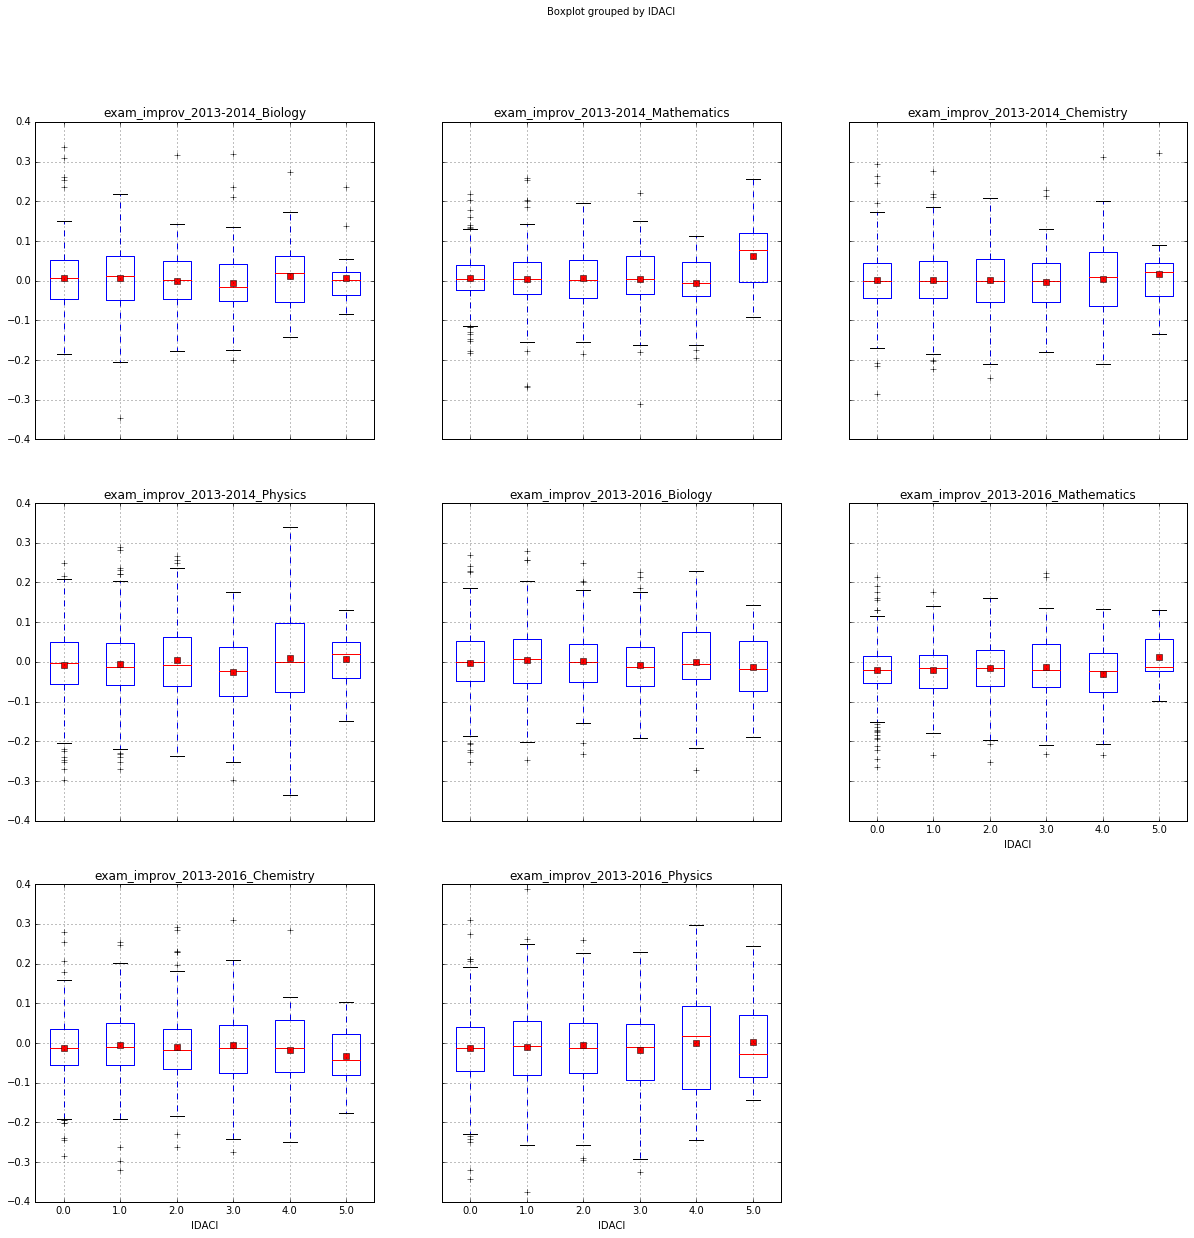

In [96]:
df.boxplot(by='IDACI', column=list(df.filter(regex='exam_improv').columns), figsize=(20,20),showmeans=True)
print('IDACI box plots')


Management Index box plots


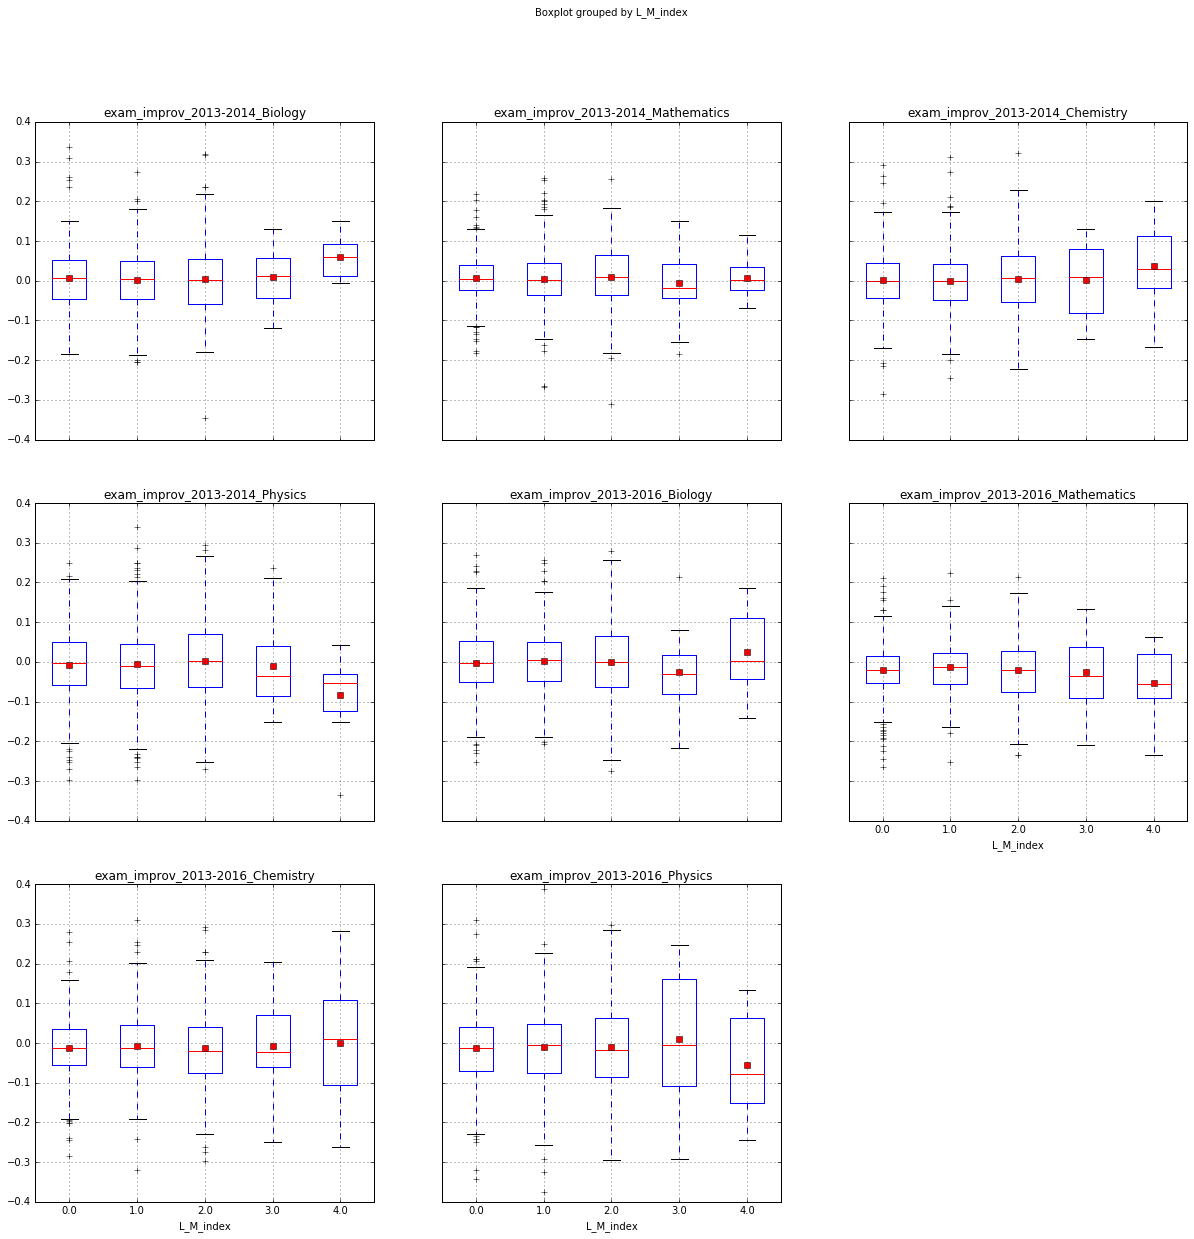

In [51]:
df.boxplot(by='L_M_index', column=list(df.filter(regex='exam_improv').columns), figsize=(20,20),showmeans=True)
print('Management Index box plots')

Teaching quality box plots


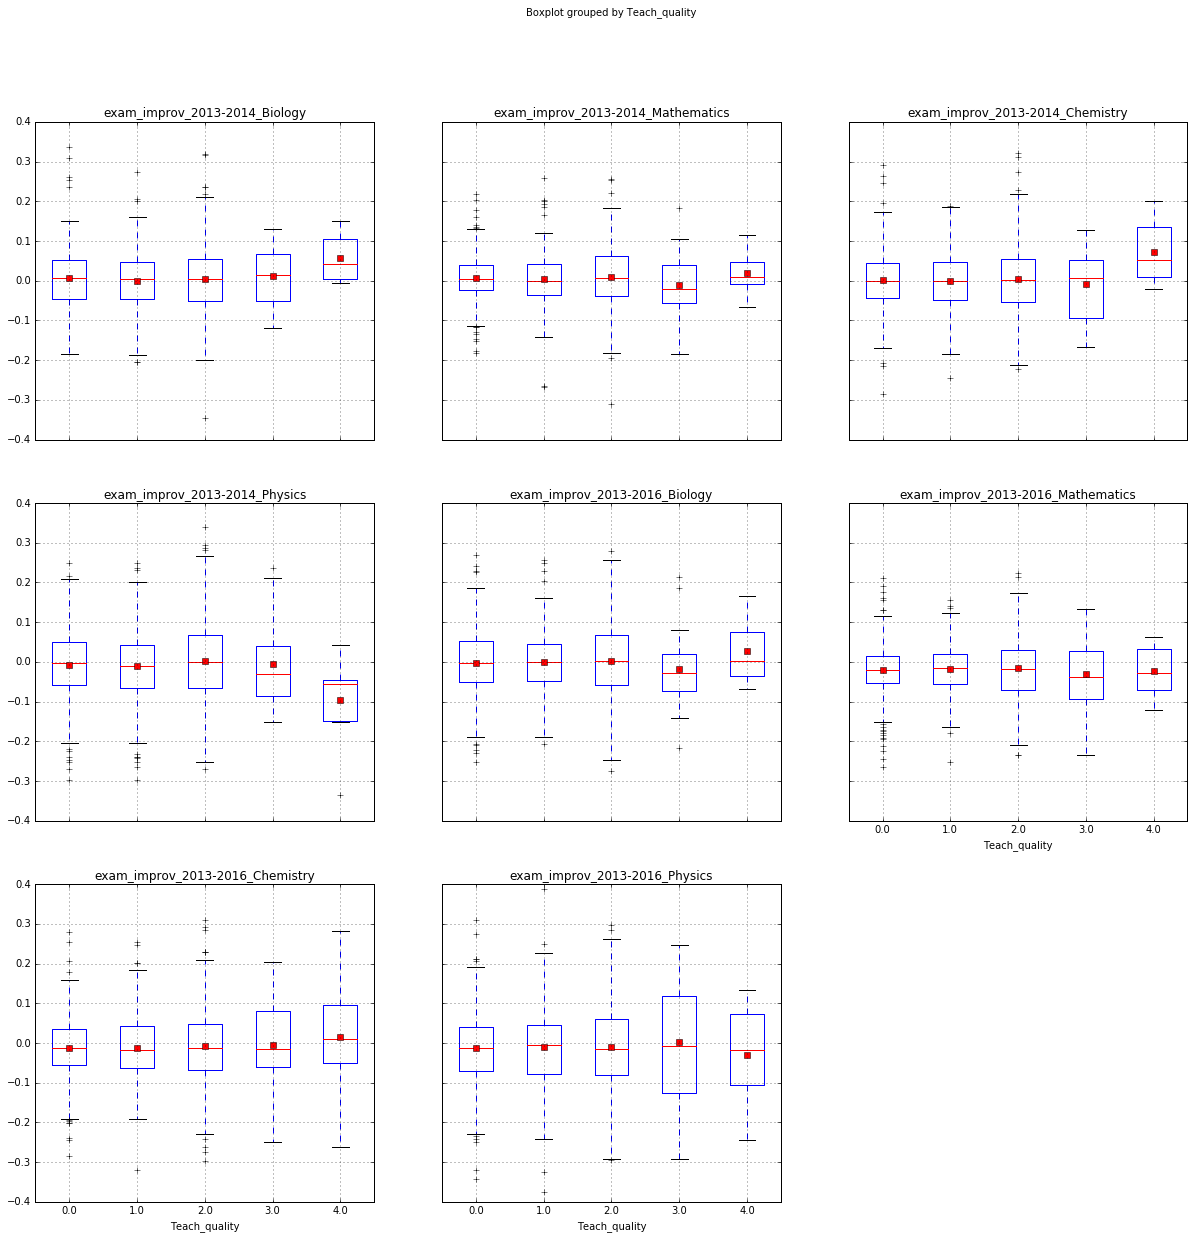

In [53]:
df.boxplot(by='Teach_quality', column=list(df.filter(regex='exam_improv').columns), figsize=(20,20),showmeans=True)
print('Teaching quality box plots')

Teaching quality box plots


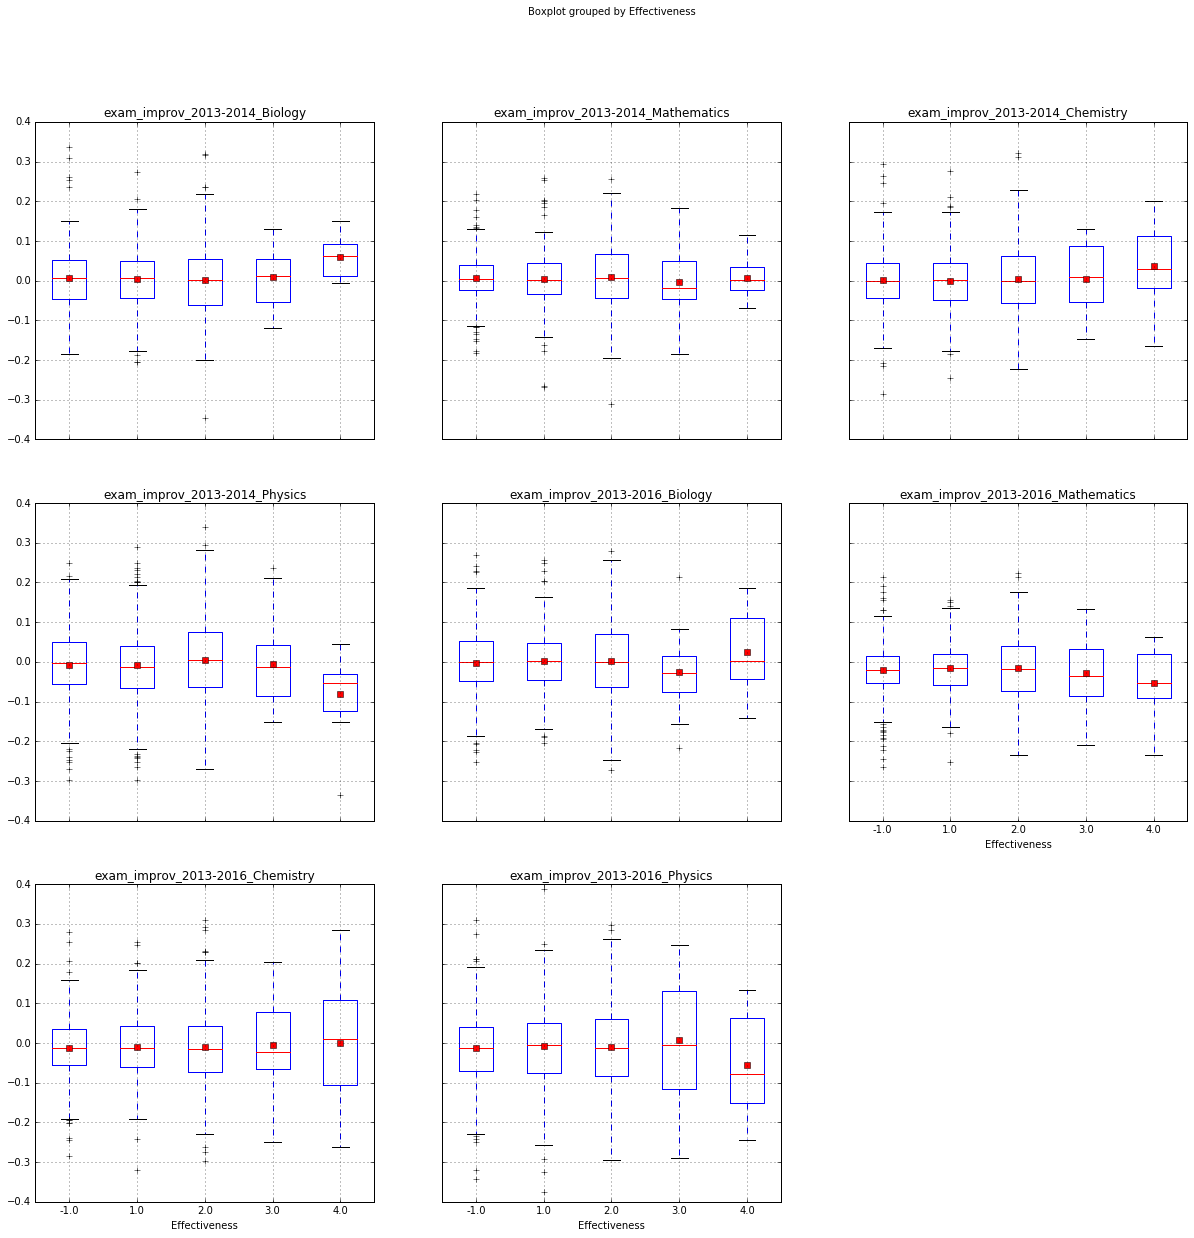

In [61]:
df.boxplot(by='Effectiveness', column=list(df.filter(regex='exam_improv').columns), figsize=(20,20),showmeans=True)
print('Teaching quality box plots')

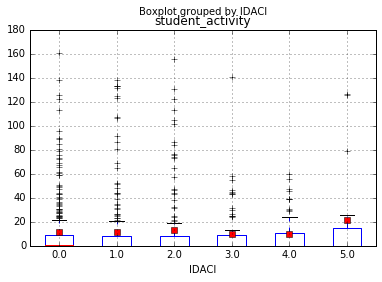

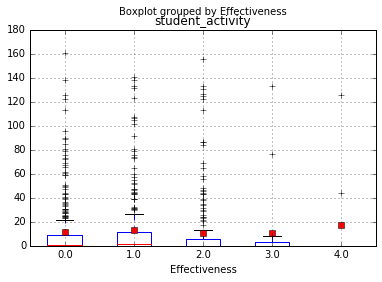

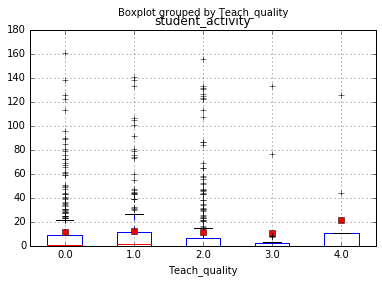

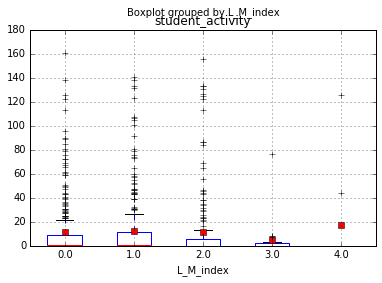

In [107]:
df_out.boxplot(by='IDACI',column='student_activity',showmeans=True)

df_out.boxplot(by='Effectiveness',column='student_activity',showmeans=True)

df_out.boxplot(by='Teach_quality',column='student_activity',showmeans=True)

df_out.boxplot(by='L_M_index',column='student_activity',showmeans=True)